In [1]:
import numpy as np
import os
from skimage import io, transform
from skimage.measure import marching_cubes
import vtk
import trimesh
import cv2 as cv
import cumcubes
import torch
import matplotlib.pyplot as plt
import psutil
import time
from functools import wraps
import tracemalloc


In [2]:
def measure_resources(func):
    """Decorator to measure execution time and memory usage (including peak)."""
    @wraps(func)
    def wrapper(*args, **kwargs):
        process = psutil.Process(os.getpid())
        
        # Record start time and memory
        tracemalloc.start()
        start_time = time.time()
        start_memory = process.memory_info().rss  # Resident Set Size in bytes
        
        result = func(*args, **kwargs)
        
        # Record end time and memory
        end_time = time.time()
        end_memory = process.memory_info().rss  # Resident Set Size in bytes
        current, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()

        # Calculate resource usage
        elapsed_time = end_time - start_time
        memory_used = (end_memory - start_memory) / (1024 * 1024)  # Convert to MB
        peak_memory = peak / (1024 * 1024)  # Convert to MB

        # Print resource usage
        print(f"Function '{func.__name__}' executed in {elapsed_time:.2f} seconds.")
        print(f"Memory change: {memory_used:.2f} MB.")
        print(f"Peak memory usage: {peak_memory:.2f} MB.")
        
        return result
    return wrapper

In [3]:
def load_image(file_path):
    with Image.open(file_path) as img:
        return np.array(img)

def load_masks_to_volume(mask_folder, kidney_folder, cuda=True, scale=1.0, blur_kernel=(25,25)):
    mask_files = sorted([f for f in os.listdir(mask_folder) if f.endswith('.tif')])
    
    first_mask = io.imread(os.path.join(mask_folder, mask_files[0]))
    height, width = first_mask.shape[:2]
    new_width, new_height = (int(width * scale), int(height * scale))
    volume_shape = (len(mask_files), int(height * scale), int(width * scale))
    
    
    volume = np.zeros(volume_shape, dtype=np.uint8)

    for i, mask_file in enumerate(mask_files):
        img = io.imread(os.path.join(mask_folder, mask_file))

        resized = transform.resize(img, (new_height, new_width), anti_aliasing=True)

        volume[i, :, :] = resized
        

    return volume


mask_folder = 'C:\\Users\\Bartek\\Desktop\\mgr\\train\\kidney_3_sparse\\labels'



In [4]:
def create_mesh_from_volume(volume, smoothing=True, level=0.5, iterations=10, cuda=True):
    if cuda:
        verts, faces = cumcubes.marching_cubes(volume, 0, verbose=True)
        verts = verts.cpu().numpy()
        faces = faces.cpu().numpy()
    else:
        verts, faces, _, _ = marching_cubes(volume, level=level)
    print("aaa")
    mesh = trimesh.Trimesh(vertices=verts, faces=faces)

    if smoothing: 
        mesh = trimesh.smoothing.filter_laplacian(mesh, iterations=iterations)

    return mesh

@measure_resources
def run():
    volume = load_masks_to_volume(mask_folder, "kidney_contour_dir", cuda=False, blur_kernel=(15,15))
    print("volume")
    blood_mesh = create_mesh_from_volume(volume, cuda=False, smoothing=False, iterations=10)
    print("mesh2")
    blood_mesh.export("scikit_mesh.obj")
    print("done")



In [5]:
run()

volume
aaa
mesh2
done
Function 'run' executed in 164.31 seconds.
Memory change: 255.02 MB.
Peak memory usage: 12924.71 MB.


In [6]:
import vtk
@measure_resources
def run():
    volume = load_masks_to_volume(mask_folder, "kidney_contour_dir", cuda=False, blur_kernel=(15,15))
    # Assume you have a 3D numpy array `volume` (stack of 2D masks)
    data_importer = vtk.vtkImageImport()
    data_importer.CopyImportVoidPointer(volume.flatten(order='F').tobytes(), volume.size)

    # Set dimensions and scalar type
    data_importer.SetDataSpacing(1, 1, 1)
    data_importer.SetDataExtent(0, volume.shape[0]-1, 0, volume.shape[1]-1, 0, volume.shape[2]-1)
    data_importer.SetWholeExtent(0, volume.shape[0]-1, 0, volume.shape[1]-1, 0, volume.shape[2]-1)
    data_importer.SetDataScalarTypeToUnsignedChar()

    # Apply Marching Cubes algorithm
    marching_cubes = vtk.vtkMarchingCubes()
    marching_cubes.SetInputConnection(data_importer.GetOutputPort())
    marching_cubes.SetValue(0, 0.5)  # Adjust value based on your mask

    # Create an STL writer
    stl_writer = vtk.vtkOBJWriter()

    # Set the output file path for the STL file
    stl_writer.SetFileName("output_mesh.obj")

    # Connect the output of the Marching Cubes algorithm to the STL writer
    stl_writer.SetInputConnection(marching_cubes.GetOutputPort())

    # Write the STL file
    stl_writer.Write()


In [7]:
run()

Function 'run' executed in 92.05 seconds.
Memory change: -2.83 MB.
Peak memory usage: 7628.24 MB.


# VIS

In [54]:
import vtk

# Assume you have a 3D numpy array `volume` (binary mask or labeled volume)
data_importer = vtk.vtkImageImport()
data_importer.CopyImportVoidPointer(volume.flatten(order='F').tobytes(), volume.size)

# Set dimensions and scalar type
data_importer.SetDataSpacing(1, 1, 1)
data_importer.SetDataExtent(0, volume.shape[0]-1, 0, volume.shape[1]-1, 0, volume.shape[2]-1)
data_importer.SetWholeExtent(0, volume.shape[0]-1, 0, volume.shape[1]-1, 0, volume.shape[2]-1)
data_importer.SetDataScalarTypeToUnsignedChar()

# Apply Discrete Marching Cubes
discrete_marching_cubes = vtk.vtkDiscreteMarchingCubes()
discrete_marching_cubes.SetInputConnection(data_importer.GetOutputPort())
discrete_marching_cubes.GenerateValues(1, 1, 1)  # Assuming label '1' corresponds to the region of interest

# Optional: Apply smoothing to the output mesh
smoother = vtk.vtkWindowedSincPolyDataFilter()
smoother.SetInputConnection(discrete_marching_cubes.GetOutputPort())
smoother.SetNumberOfIterations(20)
smoother.BoundarySmoothingOff()
smoother.FeatureEdgeSmoothingOff()
smoother.SetFeatureAngle(120.0)
smoother.SetPassBand(0.001)
smoother.NonManifoldSmoothingOn()
smoother.NormalizeCoordinatesOn()
smoother.Update()

# Create an STL writer to save the smoothed mesh
stl_writer = vtk.vtkSTLWriter()
stl_writer.SetFileName("smoothed_output_mesh.stl")
stl_writer.SetInputConnection(smoother.GetOutputPort())
stl_writer.Write()

print("Smoothed STL export complete: 'smoothed_output_mesh.stl'")

# Optionally visualize the result
mapper = vtk.vtkPolyDataMapper()
mapper.SetInputConnection(smoother.GetOutputPort())

actor = vtk.vtkActor()
actor.SetMapper(mapper)

renderer = vtk.vtkRenderer()
render_window = vtk.vtkRenderWindow()
render_window.AddRenderer(renderer)

render_interactor = vtk.vtkRenderWindowInteractor()
render_interactor.SetRenderWindow(render_window)

renderer.AddActor(actor)
renderer.SetBackground(0, 0, 0)

render_window.Render()
render_interactor.Start()


Smoothed STL export complete: 'smoothed_output_mesh.stl'


In [67]:
volume1.shape

(456, 261, 183)

# asdasdas

In [12]:
import trimesh
import pandas as pd
from trimesh.proximity import closest_point
from scipy.spatial import KDTree
import os

In [ ]:


# Funkcja obliczająca Chamfer Distance
def chamfer_distance(points1, points2):
    tree1 = KDTree(points1)
    tree2 = KDTree(points2)
    dist1, _ = tree1.query(points2)
    dist2, _ = tree2.query(points1)
    return dist1.mean() + dist2.mean()

# Funkcja obliczająca Hausdorff Distance
def hausdorff_distance(mesh1, mesh2):
    dist1 = trimesh.proximity.signed_distance(mesh1, mesh2.vertices)
    dist2 = trimesh.proximity.signed_distance(mesh2, mesh1.vertices)
    return max(dist1.max(), dist2.max())

# Funkcja obliczająca podobieństwo objętości
def volume_overlap(mesh1, mesh2):
    try:
        intersection = trimesh.boolean.intersection([mesh1, mesh2])
        overlap = intersection.volume / min(mesh1.volume, mesh2.volume)
        return overlap
    except Exception as e:
        print(f"Volume overlap computation failed: {e}")
        return 0

# Funkcja do obliczania powierzchni
def surface_area_difference(mesh1, mesh2):
    return abs(mesh1.area - mesh2.area)

# Funkcja do generowania chmury punktów
def sample_points(mesh, num_points=100000):
    return mesh.sample(num_points)

In [14]:
# Specify the directory containing .obj files
directory_path = r"C:\Users\Bartek\Desktop\mgr\stl\nower\alligned"

# Find all .obj files in the directory
obj_files = [os.path.join(directory_path, file) for file in os.listdir(directory_path) if file.endswith('.obj')]

# Check if we have enough files
if len(obj_files) < 2:
    raise ValueError("At least two .obj files are required for comparison.")

# Load the original mesh (assume the first file is the original mask)
original_mesh = trimesh.load(obj_files[0], force='mesh')
print(f"Loaded original mesh: {obj_files[0]}")

# Prepare table for results
metrics = []

# Iterate over prediction files
for file_path in obj_files[1:]:
    method = os.path.basename(file_path)
    pred_mesh = trimesh.load(file_path, force='mesh')

    # Calculate metrics
    chamfer = chamfer_distance(sample_points(original_mesh), sample_points(pred_mesh))
    hausdorff = hausdorff_distance(original_mesh, pred_mesh)
    volume_sim = volume_overlap(original_mesh, pred_mesh)
    surface_diff = surface_area_difference(original_mesh, pred_mesh)

    # Add results to table
    metrics.append({
        "Metoda": method,
        "Chamfer Distance": chamfer,
        "Hausdorff Distance": hausdorff,
        "Podobieństwo objętości": volume_sim,
        "Różnica powierzchni": surface_diff
    })

# Convert to DataFrame and display
df = pd.DataFrame(metrics)
print(df)

# Export to CSV
df.to_csv("3D_metrics_comparison.csv", index=False)
print("Results saved to 3D_metrics_comparison.csv")

Loaded original mesh: C:\Users\Bartek\Desktop\mgr\stl\nower\alligned\oryginał.obj


AttributeError: 'ModuleNotFoundError' object has no attribute 'index'

In [ ]:
df.to_latex()

In [ ]:
import open3d as o3d
import numpy as np
from scipy.spatial import KDTree
import pandas as pd
import os

# Chamfer Distance
def chamfer_distance(points1, points2):
    tree1 = KDTree(points1)
    tree2 = KDTree(points2)
    dist1, _ = tree1.query(points2)
    dist2, _ = tree2.query(points1)
    return dist1.mean() + dist2.mean()

# Hausdorff Distance
def hausdorff_distance(mesh1, mesh2):
    tree1 = KDTree(np.asarray(mesh1.vertices))
    tree2 = KDTree(np.asarray(mesh2.vertices))
    dist1, _ = tree1.query(np.asarray(mesh2.vertices))
    dist2, _ = tree2.query(np.asarray(mesh1.vertices))
    return max(dist1.max(), dist2.max())

# Volume Overlap
def volume_overlap(mesh1, mesh2):
    try:
        from trimesh.boolean import intersection
        vol1 = mesh1.get_volume()
        vol2 = mesh2.get_volume()
        intersection_vol = intersection(mesh1, mesh2).get_volume()
        return intersection_vol / min(vol1, vol2)
    except Exception as e:
        print(f"Volume overlap computation failed: {e}")
        return 0

# Surface Area Difference
def surface_area_difference(area1, area2):
    return abs(area1 - area2)

# Load meshes with Open3D
def load_mesh(file_path):
    return o3d.io.read_triangle_mesh(file_path)

# Compute surface area and volume using Open3D
def compute_surface_area_and_volume(mesh):
    """
    Compute the surface area and volume of a mesh, ensuring the mesh is closed.
    """
    mesh.compute_triangle_normals()
    mesh.compute_vertex_normals()
    surface_area = mesh.get_surface_area()

    # Attempt to clean the mesh if not watertight
    if not mesh.is_watertight():
        print("Mesh is not watertight. Attempting to clean...")
        # Try to repair the mesh
        mesh = mesh.remove_non_manifold_edges()
        mesh = mesh.remove_duplicated_triangles()
        mesh = mesh.remove_degenerate_triangles()
        mesh = mesh.remove_duplicated_vertices()
        mesh = mesh.remove_unreferenced_vertices()
        if not mesh.is_watertight():
            print("Failed to close the mesh. Volume will be set to 0.")
            return surface_area, 0

    # Compute volume for watertight mesh
    try:
        volume = mesh.get_volume()
    except Exception as e:
        print(f"Failed to compute volume: {e}")
        volume = 0

    return surface_area, volume

# Directory containing OBJ files
directory_path = r"C:\Users\Bartek\Desktop\mgr\stl\nower\alligned"

# Find all OBJ files in the directory
obj_files = [os.path.join(directory_path, file) for file in os.listdir(directory_path) if file.endswith('.obj')]

if len(obj_files) < 2:
    raise ValueError("At least two OBJ files are required for comparison.")

# Load the reference mesh (first file in the list)
reference_mesh = load_mesh(obj_files[0])
ref_surface_area, ref_volume = compute_surface_area_and_volume(reference_mesh)
print(f"Loaded reference mesh: {obj_files[0]}")

# Prepare table for results
metrics = []

# Iterate over all prediction meshes
for file_path in obj_files[1:]:
    method = os.path.basename(file_path)
    prediction_mesh = load_mesh(file_path)
    pred_surface_area, pred_volume = compute_surface_area_and_volume(prediction_mesh)

    # Calculate metrics
    chamfer = chamfer_distance(np.asarray(reference_mesh.sample_points_uniformly(10000).points),
                               np.asarray(prediction_mesh.sample_points_uniformly(10000).points))
    hausdorff = hausdorff_distance(reference_mesh, prediction_mesh)
    vol_overlap = volume_overlap(reference_mesh, prediction_mesh)
    surf_diff = surface_area_difference(ref_surface_area, pred_surface_area)

    # Add results to table
    metrics.append({
        "Metoda": method,
        "Chamfer Distance": chamfer,
        "Hausdorff Distance": hausdorff,
        "Volume Overlap": vol_overlap,
        "Surface Area Difference": surf_diff
    })

# Convert metrics to a DataFrame
df = pd.DataFrame(metrics)
print(df)

# Save results to a CSV
df.to_csv("3D_metrics_comparison.csv", index=False)
print("Results saved to 3D_metrics_comparison.csv")


In [ ]:
import trimesh
import os

def convert_stl_to_obj(input_directory, output_directory):
    # Ensure output directory exists
    os.makedirs(output_directory, exist_ok=True)

    # Iterate through all STL files in the input directory
    for filename in os.listdir(input_directory):
        if filename.endswith(".stl"):
            input_path = os.path.join(input_directory, filename)
            output_filename = os.path.splitext(filename)[0] + ".obj"
            output_path = os.path.join(output_directory, output_filename)

            try:
                # Load the STL file
                mesh = trimesh.load(input_path)

                # Export the mesh to OBJ format
                mesh.export(output_path)
                print(f"Converted {filename} to {output_filename}")
            except Exception as e:
                print(f"Error converting {filename}: {e}")

# Specify input and output directories
input_dir = r"C:\Users\Bartek\Desktop\mgr\stl\nower"
output_dir = r"C:\Users\Bartek\Desktop\mgr\stl\nower"

convert_stl_to_obj(input_dir, output_dir)


In [ ]:
pred_masks = np.memmap(r"C:\Users\Bartek\Desktop\mgr\stl\nower\kidney_3_dust.mmap", shape=(1035, 1706, 1510), dtype=np.uint8, mode="r")

In [21]:

volume = pred_masks
# Assume you have a 3D numpy array `volume` (stack of 2D masks)
data_importer = vtk.vtkImageImport()
data_importer.CopyImportVoidPointer(volume.flatten(order='F').tobytes(), volume.size)

# Set dimensions and scalar type
data_importer.SetDataSpacing(1, 1, 1)
data_importer.SetDataExtent(0, volume.shape[0]-1, 0, volume.shape[1]-1, 0, volume.shape[2]-1)
data_importer.SetWholeExtent(0, volume.shape[0]-1, 0, volume.shape[1]-1, 0, volume.shape[2]-1)
data_importer.SetDataScalarTypeToUnsignedChar()

# Apply Marching Cubes algorithm
marching_cubes = vtk.vtkMarchingCubes()
marching_cubes.SetInputConnection(data_importer.GetOutputPort())
marching_cubes.SetValue(0, 0.5)  # Adjust value based on your mask

# Create an STL writer
stl_writer = vtk.vtkSTLWriter()

# Set the output file path for the STL file
stl_writer.SetFileName("output_mesh_dust.stl")

# Connect the output of the Marching Cubes algorithm to the STL writer
stl_writer.SetInputConnection(marching_cubes.GetOutputPort())

# Write the STL file
stl_writer.Write()


1

In [50]:
import os
import numpy as np
import cv2
from tqdm import tqdm

def export_slice_from_mmap(mmap_path, volume_shape, slice_index):
    """
    Extracts a specific slice from a memory-mapped volume.
    """
    mmap_data = np.memmap(mmap_path, dtype=np.uint8, mode='r', shape=volume_shape)
    slice_data = mmap_data[slice_index]
    return slice_data

def load_slice_from_dir(slice_dir, slice_filename):
    """
    Loads a single slice image from a directory.
    """
    slice_path = os.path.join(slice_dir, slice_filename)
    if not os.path.exists(slice_path):
        raise FileNotFoundError(f"File not found: {slice_path}")
    slice_image = cv2.imread(slice_path, cv2.IMREAD_GRAYSCALE)
    return slice_image

def save_abs_diff_image(image1, image2, output_path):
    """
    Computes the absolute difference between two images and saves it.
    """
    abs_diff = cv2.absdiff(image1, image2)
    cv2.imwrite(output_path, abs_diff)

# Configuration
mmap_path = r"C:\Users\Bartek\Desktop\mgr\stl\nower\kidney_3.mmap"
volume_shape = (1035, 1706, 1510)  # Example shape of the volume
slice_index = 850  # Index of the slice to export from mmap
slice_dir = r"C:\Users\Bartek\Desktop\mgr\train\kidney_3_sparse\labels"
slice_filename = f"0{slice_index}.tif"  # Filename of the corresponding slice in the directory
output_path = "abs_diff.png"  # Path to save the absolute difference image


mmap_slice = export_slice_from_mmap(mmap_path, volume_shape, slice_index)
print(f"Extracted slice {slice_index} from mmap.")

# Load slice from directory
dir_slice = load_slice_from_dir(slice_dir, slice_filename)
dir_slice = (dir_slice > 0).astype(int)
print(f"Loaded slice '{slice_filename}' from directory.")




Extracted slice 850 from mmap.
Loaded slice '0850.tif' from directory.


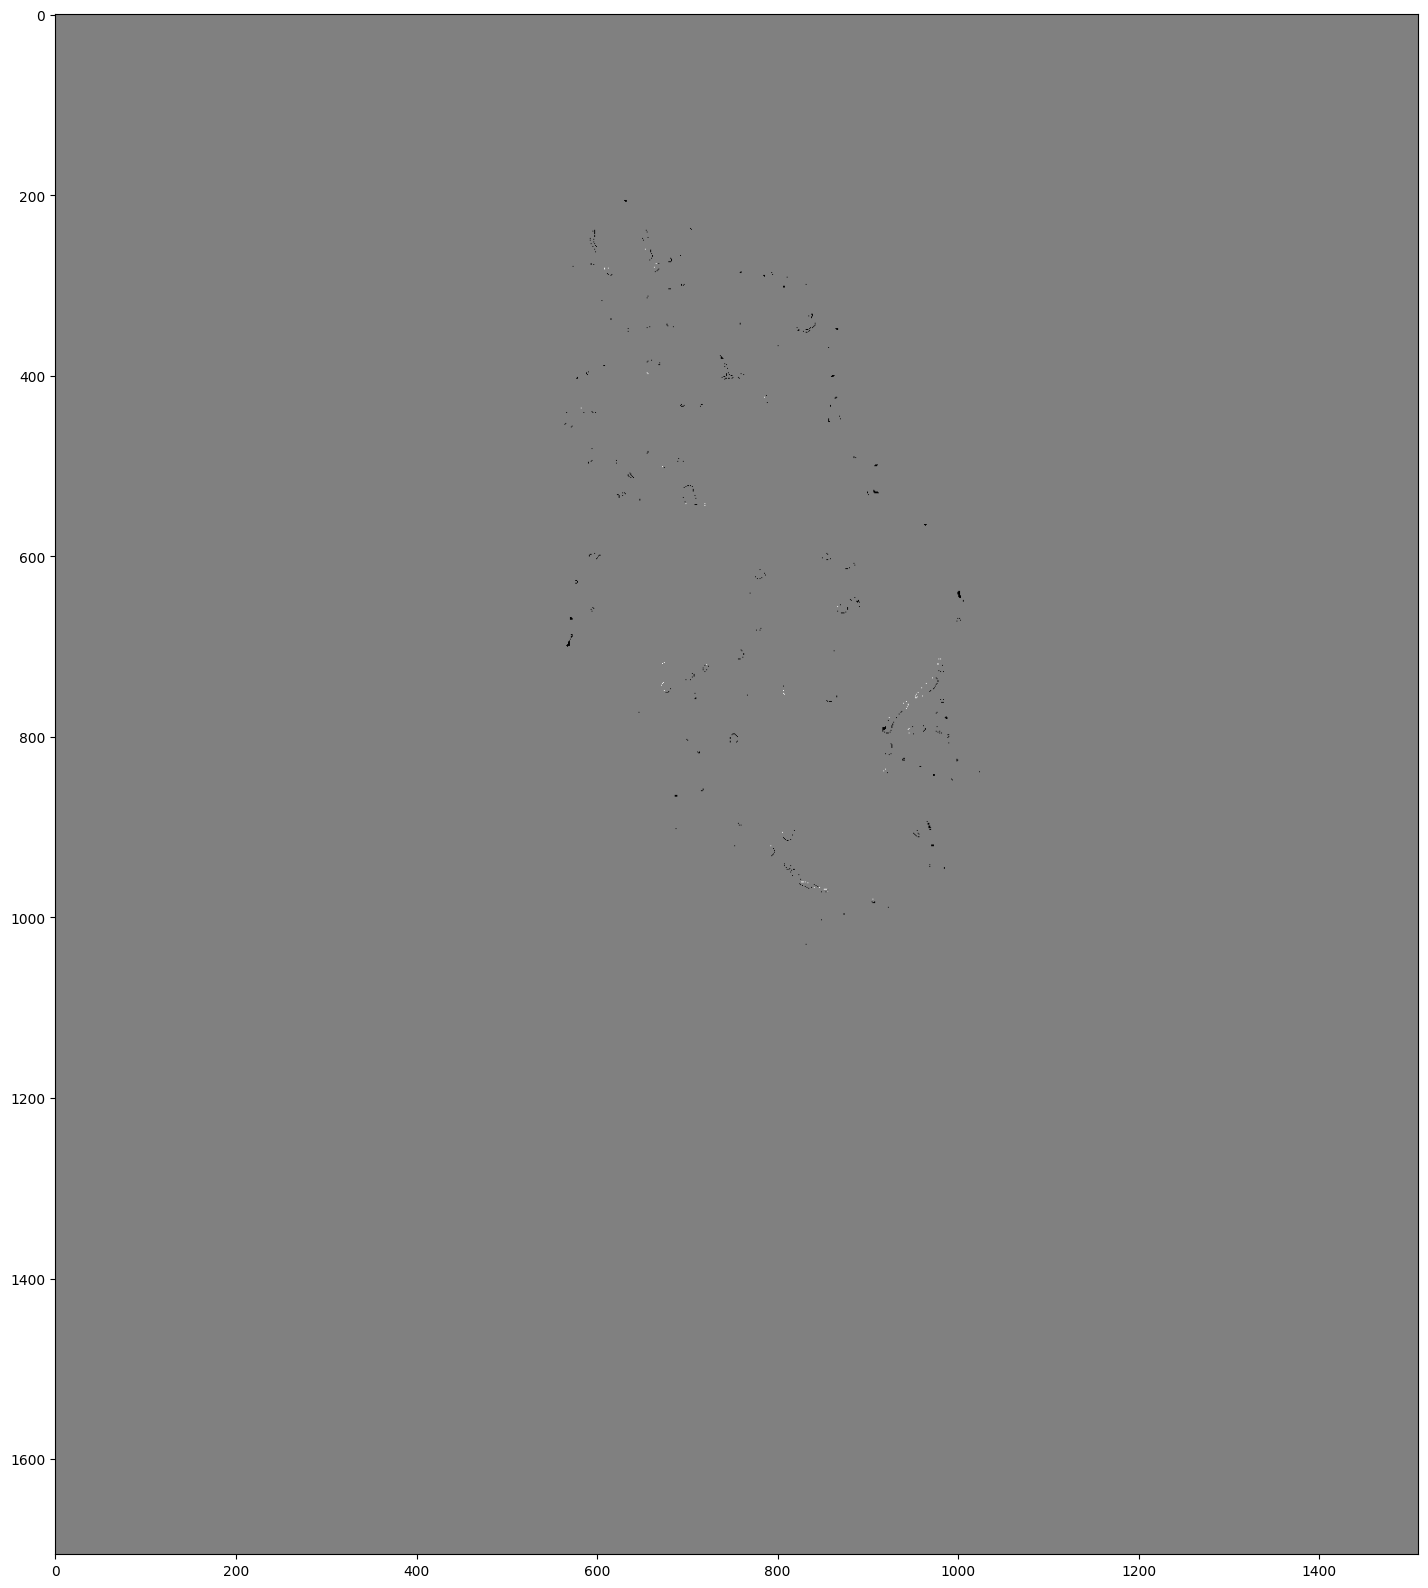

In [52]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
plt.imshow(dir_slice - mmap_slice  , cmap='gray')

In [ ]:
import vtk

# Load the meshes
source_reader = vtk.vtkOBJReader()
source_reader.SetFileName(r"C:\Users\Bartek\Desktop\mgr\stl\test\untitled.obj")
source_reader.Update()
source = source_reader.GetOutput()

target_reader = vtk.vtkOBJReader()
target_reader.SetFileName(r"C:\Users\Bartek\Desktop\mgr\stl\test\untitled1.obj")
target_reader.Update()
target = target_reader.GetOutput()

# Apply ICP
icp = vtk.vtkIterativeClosestPointTransform()
icp.SetSource(source)
icp.SetTarget(target)
icp.GetLandmarkTransform().SetModeToRigidBody()
icp.SetMaximumNumberOfIterations(50000)
icp.StartByMatchingCentroidsOn()
icp.Update()

# Transform the source mesh
transform_filter = vtk.vtkTransformPolyDataFilter()
transform_filter.SetInputData(source)
transform_filter.SetTransform(icp)
transform_filter.Update()
aligned_source = transform_filter.GetOutput()

# Visualize the aligned meshes
mapper1 = vtk.vtkPolyDataMapper()
mapper1.SetInputData(aligned_source)
actor1 = vtk.vtkActor()
actor1.SetMapper(mapper1)
actor1.GetProperty().SetColor(1, 0, 0)  # Red

mirror_transform = vtk.vtkTransform()
mirror_transform.Scale(1, 1, -1)  # Mirror across the X-axis
#actor1.SetUserTransform(mirror_transform)

mapper2 = vtk.vtkPolyDataMapper()
mapper2.SetInputData(target)
actor2 = vtk.vtkActor()
actor2.SetMapper(mapper2)
actor2.GetProperty().SetColor(0, 0, 1)  # Blue

#actor1.RotateZ(180)
#actor1.RotateY(15)

renderer = vtk.vtkRenderer()
renderer.AddActor(actor1)
renderer.AddActor(actor2)
renderer.SetBackground(0, 0, 0)

render_window = vtk.vtkRenderWindow()
render_window.AddRenderer(renderer)
render_window.Render()

interactor = vtk.vtkRenderWindowInteractor()
interactor.SetRenderWindow(render_window)
interactor.Start()


In [2]:
import vtk

def visualize_objs_with_vtk(file1, file2, output_screenshot=None):
    """
    Visualize two OBJ files using VTK with distinct colors and black background.
    Apply a 90-degree rotation on the Y-axis to the red object.
    
    Parameters:
    - file1 (str): Path to the first OBJ file.
    - file2 (str): Path to the second OBJ file.
    - output_screenshot (str): Path to save the screenshot. If None, no screenshot is saved.
    """
    # Load first OBJ file
    reader1 = vtk.vtkOBJReader()
    reader1.SetFileName(file1)
    reader1.Update()

    # Load second OBJ file
    reader2 = vtk.vtkOBJReader()
    reader2.SetFileName(file2)
    reader2.Update()

    # Create mappers for the meshes
    mapper1 = vtk.vtkPolyDataMapper()
    mapper1.SetInputConnection(reader1.GetOutputPort())

    mapper2 = vtk.vtkPolyDataMapper()
    mapper2.SetInputConnection(reader2.GetOutputPort())

    # Create actors for the meshes
    actor1 = vtk.vtkActor()
    actor1.SetMapper(mapper1)
    actor1.GetProperty().SetColor(1, 0, 0)  # Red
    actor1.GetProperty().SetOpacity(0.8)

    actor2 = vtk.vtkActor()
    actor2.SetMapper(mapper2)
    actor2.GetProperty().SetColor(0, 0, 1)  # Blue
    actor2.GetProperty().SetOpacity(1)

    legend_text_red = vtk.vtkTextActor()
    legend_text_red.SetInput("Oryginał  -  ")
    legend_text_red.GetTextProperty().SetFontSize(25)
    legend_text_red.SetPosition(10, 70)

    legend_text_blue = vtk.vtkTextActor()
    legend_text_blue.SetInput("Predykcja  -  ")
    legend_text_blue.GetTextProperty().SetFontSize(25)
    legend_text_blue.SetPosition(10, 35)

    legend_background = vtk.vtkTexturedActor2D()
    background_image = vtk.vtkImageCanvasSource2D()
    background_image.SetExtent(0, 200, 0, 100, 0, 0)
    background_image.SetDrawColor(0.5, 0.5, 0.5, 1)  # Grey color
    background_image.FillBox(0, 200, 0, 100)
    background_image.Update()

    background_mapper = vtk.vtkImageMapper()
    background_mapper.SetInputConnection(background_image.GetOutputPort())

    legend_background.SetMapper(background_mapper)
    legend_background.GetPositionCoordinate().SetValue(10, 10)  # Bottom-left corner of the legend
    legend_background.SetPosition2(0.2, 0.1)  # Adjust size of the rectangle

    # Create a renderer and set the background to black
    renderer = vtk.vtkRenderer()
    renderer.SetBackground(0, 0, 0)
    renderer.AddActor(actor1)
    renderer.AddActor(actor2)

    # Create a render window
    render_window = vtk.vtkRenderWindow()
    render_window.AddRenderer(renderer)
    render_window.SetSize(1024, 1024)

    # Create an interactor for user interaction
    interactor = vtk.vtkRenderWindowInteractor()
    interactor.SetRenderWindow(render_window)

    # Start the visualization
    render_window.Render()
    if output_screenshot:
        # Capture a screenshot
        window_to_image_filter = vtk.vtkWindowToImageFilter()
        window_to_image_filter.SetInput(render_window)
        window_to_image_filter.Update()

        writer = vtk.vtkPNGWriter()
        writer.SetFileName(output_screenshot)
        writer.SetInputConnection(window_to_image_filter.GetOutputPort())
        writer.Write()
        print(f"Screenshot saved to {output_screenshot}")

    interactor.Start()

# File paths
file1 = r"C:\Users\Bartek\Desktop\mgr\stl\nower\untitled.obj"
file2 = r"C:\Users\Bartek\Desktop\mgr\stl\nower\untitled1.obj"
output_screenshot = "visualization_screenshot.png"  # Path to save the screenshot

# Visualize the OBJ files
visualize_objs_with_vtk(file1, file2, output_screenshot=output_screenshot)


ModuleNotFoundError: No module named 'vtk'

In [9]:
import os 
os.getcwd()

'c:\\Users\\Bartek\\Desktop\\mgr'

In [ ]:
#!/usr/bin/env python

import vtkmodules.vtkInteractionStyle
import vtkmodules.vtkRenderingOpenGL2
from vtkmodules.vtkCommonColor import vtkNamedColors
from vtkmodules.vtkIOGeometry import vtkOBJReader
from vtkmodules.vtkRenderingCore import (
    vtkActor,
    vtkPolyDataMapper,
    vtkRenderWindow,
    vtkRenderWindowInteractor,
    vtkRenderer,
    vtkWindowToImageFilter,
)
from vtkmodules.vtkIOImage import vtkPNGWriter


class vtkTimerCallback:
    def __init__(self, renderer, steps, render_window, save_frames=True):
        self.renderer = renderer
        self.timer_count = 0
        self.steps = steps
        self.render_window = render_window
        self.save_frames = save_frames
        self.step_angle = 360 / steps
        self.window_to_image_filter = vtkWindowToImageFilter()
        self.window_to_image_filter.SetInput(render_window)
        self.window_to_image_filter.SetInputBufferTypeToRGB()
        self.window_to_image_filter.ReadFrontBufferOff()

    def execute(self, obj, event):
        if self.timer_count < self.steps:
            # Rotate the camera
            self.renderer.GetActiveCamera().Azimuth(self.step_angle)
            self.renderer.ResetCameraClippingRange()

            # Render the scene
            self.render_window.Render()

            # Explicitly update the filter to capture the current frame
            if self.save_frames:
                self.window_to_image_filter.Modified()  # Force filter update
                self.window_to_image_filter.Update()
                writer = vtkPNGWriter()
                writer.SetInputConnection(self.window_to_image_filter.GetOutputPort())
                writer.SetFileName(f"frame_{self.timer_count:03d}.png")
                writer.Write()

            self.timer_count += 1
        else:
            # Stop the timer
            obj.DestroyTimer(obj.GetTimerId())


def main():
    colors = vtkNamedColors()

    # File paths for your OBJ models
    file1 = r"C:\Users\Bartek\Desktop\mgr\stl\nower\mc_vdb.obj"
    file2 = r"C:\Users\Bartek\Desktop\mgr\stl\nower\alligned\predykcja.obj"

    # Load first OBJ file
    reader1 = vtkOBJReader()
    reader1.SetFileName(file1)
    reader1.Update()

    # Load second OBJ file
    reader2 = vtkOBJReader()
    reader2.SetFileName(file2)
    reader2.Update()

    # Create mappers for the models
    mapper1 = vtkPolyDataMapper()
    mapper1.SetInputConnection(reader1.GetOutputPort())

    mapper2 = vtkPolyDataMapper()
    mapper2.SetInputConnection(reader2.GetOutputPort())

    # Create actors for the models
    actor1 = vtkActor()
    actor1.SetMapper(mapper1)
    actor1.GetProperty().SetColor(.3, .3, .3)  # Gray
    actor1.GetProperty().SetOpacity(1)

    actor2 = vtkActor()
    actor2.SetMapper(mapper2)
    actor2.GetProperty().SetColor(0, 0, 1)  # Blue
    actor2.GetProperty().SetOpacity(0.8)

    # Setup a renderer, render window, and interactor
    renderer = vtkRenderer()
    renderer.SetBackground(1, 1, 1)  # White background
    render_window = vtkRenderWindow()
    render_window.SetSize(2560, 2560)  # Increased window size
    render_window.SetWindowName("Smooth Rotation Animation (Save Frames)")
    render_window.AddRenderer(renderer)

    render_window_interactor = vtkRenderWindowInteractor()
    render_window_interactor.SetRenderWindow(render_window)

    # Add actors to the renderer
    renderer.AddActor(actor1)
    #renderer.AddActor(actor2)

    # Position the camera
    renderer.GetActiveCamera().SetPosition(0, 0, 500)
    renderer.GetActiveCamera().SetFocalPoint(0, 0, 0)
    renderer.ResetCamera()
    render_window.Render()

    # Timer callback for smooth rotation
    duration = 10  # Duration of animation in seconds
    fps = 60  # Frames per second
    steps = duration * fps  # Total number of steps for the animation
    cb = vtkTimerCallback(renderer, steps, render_window, save_frames=True)
    render_window_interactor.AddObserver("TimerEvent", cb.execute)
    render_window_interactor.CreateRepeatingTimer(int(1000 / fps))  # Timer interval in ms

    # Start the interaction
    render_window_interactor.Start()


if __name__ == "__main__":
    main()


AttributeError: 'vtkmodules.vtkRenderingUI.vtkWin32RenderWindowInte' object has no attribute 'GetTimerId'

In [ ]:
import vtk

def compute_and_export_intersection(file1, file2, output_path):
    # Load first mesh
    reader1 = vtk.vtkOBJReader()
    reader1.SetFileName(file1)
    reader1.Update()

    # Load second mesh
    reader2 = vtk.vtkOBJReader()
    reader2.SetFileName(file2)
    reader2.Update()

    # Apply boolean intersection
    boolean_filter = vtk.vtkBooleanOperationPolyDataFilter()
    boolean_filter.SetOperationToIntersection()  # Perform intersection
    boolean_filter.SetInputData(0, reader1.GetOutput())
    boolean_filter.SetInputData(1, reader2.GetOutput())
    boolean_filter.Update()

    # Write the result to an OBJ file
    writer = vtk.vtkOBJWriter()
    writer.SetFileName(output_path)
    writer.SetInputData(boolean_filter.GetOutput())
    writer.Write()
    print(f"Intersection exported to {output_path}")

# Paths to input and output meshes
file1 = r"C:\Users\Bartek\Desktop\mgr\stl\nower\alligned\oryginał.obj"
file2 = r"C:\Users\Bartek\Desktop\mgr\stl\nower\alligned\predykcja.obj"
output_path = "intersection_output.obj"

# Export intersection
compute_and_export_intersection(file1, file2, output_path)
